[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tuw-geo/tuw_education_notebooks/bee07addf02b7fb6a690f1ee26ed2297f25d3f4c?urlpath=lab%2Ftree%2F01_notebook_as_an_app.de.ipynb)

![Bild vom [wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)


In [1]:
%matplotlib widget

import numpy as np
from eomaps import Maps

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_bayes_flood import sig0_dc, calc_likelihoods

## Von der Rückstreuung zur Hochwasserkartierung

In diesem Notebook wird erklärt, wie die Rückstreuung von Mikrowellen ($\sigma^0$) (@fig-area) verwendet werden kann, um das Ausmaß eines Hochwassers zu kartieren. Wir replizieren in dieser Übung die Arbeit von @bauer-marschallinger_satellitenbasiert_2022 über den Bayesian-basierten Hochwasserkartierungsalgorithmus der TU Wien.

In den folgenden Zeilen erstellen wir eine Karte mit EOmaps [@quast_getting_2024] der $\sigma^0$ Rückstreuwerte.


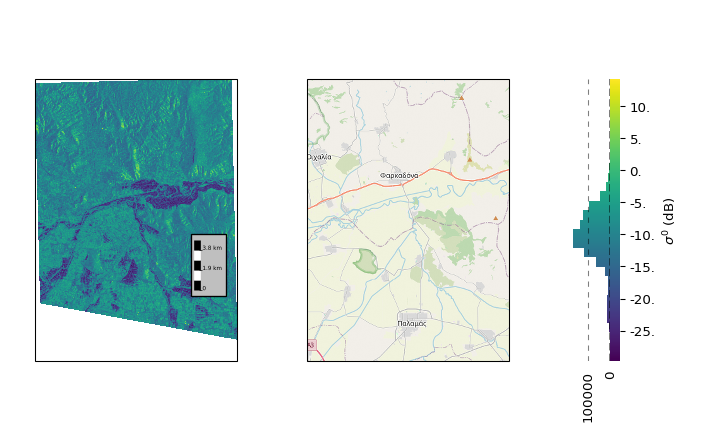

In [2]:
#| label: fig-area
#| fig-cap: 'Zielgebiet der $\sigma^0$-Rückstreuung ist die griechische Region Thessalien, die im Februar 2018 von einer großen Überschwemmung betroffen war.'
m = Maps(ax=121, crs=3857)
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=Maps.CRS.Equi7_EU)
m.plot_map()
m.add_colorbar(label="$\sigma^0$ (dB)", orientation="vertical", hist_bins=30)
m.add_scalebar(n=5)
m2 = m.new_map(ax=122, crs=3857)
m2.set_extent(m.get_extent())
m2.add_wms.OpenStreetMap.add_layer.default()
m.apply_layout(
    {
        'figsize': [7.32, 4.59],
        '0_map': [0.05, 0.18, 0.35, 0.64],
        '1_cb': [0.8125, 0.1, 0.1, 0.8],
        '1_cb_histogram_size': 0.8,
        '2_map': [0.4375, 0.18, 0.35, 0.64]
        }
    )
m.show()

## Mikrowellenrückstreuung über Land und Wasser

Reverend Bayes befasste sich mit zwei Ereignissen, von denen das eine (die *Hypothese*) vor dem anderen (dem *Beweis*) eintrat. Wenn wir die Ursache kennen, ist es leicht, logisch auf die Wahrscheinlichkeit einer Wirkung zu schließen. In diesem Fall wollen wir jedoch die Wahrscheinlichkeit einer Ursache aus einer beobachteten Wirkung ableiten, auch bekannt als "umgekehrte Wahrscheinlichkeit". Im Fall der Hochwasserkartierung haben wir $\sigma^0$ Rückstreuungsbeobachtungen über Land (die Wirkung), und wir wollen die Wahrscheinlichkeit von Überflutung ($F$) und Nicht-Überflutung ($NF$) ableiten. 

Mit anderen Worten, wir wollen die Überflutungswahrscheinlichkeit $P(F)$ bei einem Pixel mit $\sigma^0$ wissen:

$$P(F|\sigma^0)$$

und die Wahrscheinlichkeit, dass ein Pixel nicht überflutet wird $P(NF)$ bei einem bestimmten $\sigma^0$:

$$P(NF|\sigma^0).$$

Bayes zeigte, dass diese aus der Beobachtung abgeleitet werden können, dass die Vorwärts- und Rückwärtswahrscheinlichkeit gleich sind, so dass:

$$P(F|\sigma^0)P(\sigma^0) = P(\sigma^0|F)P(F)$$

und

$$P(NF|\sigma^0)P(\sigma^0) = P(\sigma^0|NF)P(NF).$$


Die Vorwärtswahrscheinlichkeit von $\sigma^0$ für das Auftreten von Überschwemmungen ($P(\sigma^0|F)$) und $\sigma^0$ für das Ausbleiben von Überschwemmungen ($P(\sigma^0|NF)$) lässt sich aus früheren Informationen über die Rückstreuung über Land- und Wasserflächen ableiten. Wie in der folgenden Skizze (@fig-sat) zu sehen ist, unterscheiden sich die Eigenschaften der Rückstreuung über Land und Wasser erheblich.

Schematische Rückstreuung über Land und Wasser. Bild von [Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jp)

## Likelihoods

Die so genannten Likelihoods von $P(\sigma^0|F)$ und $P(\sigma^0|NF)$ lassen sich also aus den Rückstreuungsinformationen der Vergangenheit berechnen. Ohne auf die Einzelheiten der Berechnung dieser Wahrscheinlichkeiten einzugehen, kann man **auf** ein Pixel der Karte klicken, um die Wahrscheinlichkeiten für $\sigma^0$ für Land oder Wasser darzustellen.


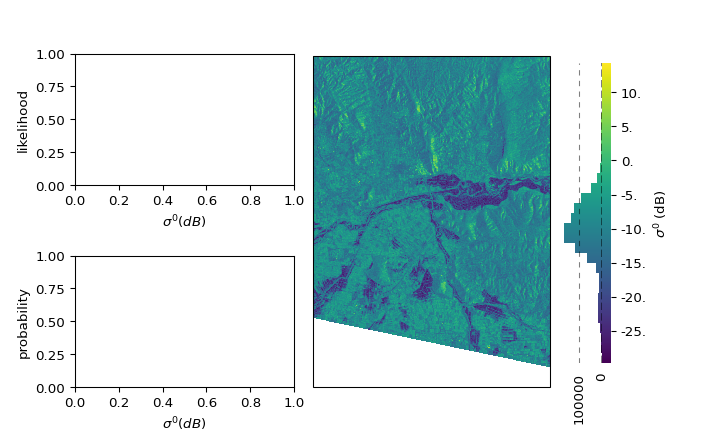

In [3]:
#| label: fig-lik
#| fig-cap: 'Wahrscheinlichkeiten dafür, dass $\\sigma^0$ mit Land oder Wasser assoziiert ist, für 1 Pixel im griechischen Gebiet von Thessalien. Die Wahrscheinlichkeiten werden über einen Bereich von $\\sigma^0$ berechnet. Der beobachtete $\\sigma^0$ des Pixels ist durch eine vertikale Linie dargestellt. Klicken Sie auf die Karte, um diese Abbildung für ein anderes Pixel im Untersuchungsgebiet neu zu berechnen und zu aktualisieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.'
view_bayes_flood(sig0_dc)

## Posterioren

Nach der Berechnung der Likelihoods können wir nun die Wahrscheinlichkeit des (Nicht-)Flutens eines Pixels mit $\sigma^0$ berechnen. Diese so genannten *Posterioren* benötigen eine weitere Information, wie aus der obigen Gleichung ersichtlich ist. Wir benötigen die Wahrscheinlichkeit, dass ein Pixel überflutet $P(F)$ oder nicht überflutet $P(NF)$ ist. Das sind natürlich die Zahlen, die wir schon die ganze Zeit zu finden versuchen. Wir haben sie aber noch nicht, was können wir also tun? In der Bayes'schen Statistik können wir einfach mit unserer besten Schätzung beginnen. Diese Vermutungen werden als "Prioren" bezeichnet, weil sie die Überzeugungen sind, die wir *vor* der Betrachtung der Daten haben. Diese subjektive Vorannahme ist die Grundlage der Bayes'schen Statistik, und wir verwenden die soeben berechneten Likelihoods, um unseren Glauben an diese bestimmte Hypothese zu aktualisieren. Diese aktualisierte Überzeugung wird als "Posterior" bezeichnet.

Nehmen wir an, unsere beste Schätzung für die Wahrscheinlichkeit, dass ein Pixel überflutet oder nicht überflutet wird, ist 50:50: ein Münzwurf.  Wir können nun auch die Rückstreuungswahrscheinlichkeit $P(\sigma^0)$ als gewichteten Durchschnitt der Wasser- und Landwahrscheinlichkeiten berechnen, um sicherzustellen, dass unsere Posterioren zwischen 0 und 1 liegen.

Der folgende Codeblock zeigt, wie wir die Prioritäten berechnen.


In [4]:
def calc_posteriors(water_likelihood, land_likelihood):
    evidence = (water_likelihood * 0.5) + (land_likelihood * 0.5)
    return (water_likelihood * 0.5) / evidence,  (land_likelihood * 0.5) / evidence

Wir können die Posterior-Wahrscheinlichkeiten für Überflutung und Nicht-Überflutung erneut darstellen und mit dem gemessenen $\sigma^0$ des Pixels vergleichen. Man kann auf ein Pixel **klicken**, um die Posterior-Wahrscheinlichkeit zu berechnen.


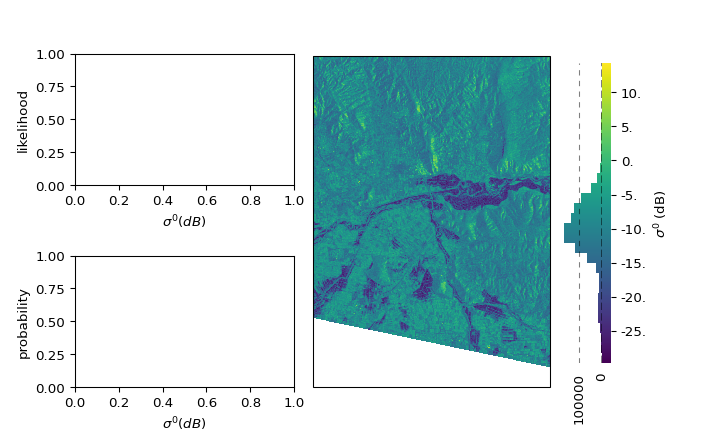

In [5]:
#| label: fig-post
#| fig-cap: 'Posteriorwahrscheinlichkeiten für $\sigma^0$, dass 1 Pixel mit Land für Wasser im griechischen Gebiet Thessalien assoziiert ist. Klicken Sie auf die Karte, um diese Abbildung für ein anderes Pixel im Untersuchungsgebiet neu zu berechnen und zu aktualisieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.'
view_bayes_flood(sig0_dc, calc_posteriors)

## Klassifizierung von Überschwemmungen

Nun können wir all diese Informationen kombinieren und die Pixel anhand des Rückstreuungswerts jedes Pixels nach der Überflutungswahrscheinlichkeit klassifizieren. Hier schauen wir nur, ob die Wahrscheinlichkeit einer Überflutung höher ist als die einer Nicht-Überflutung:


In [6]:
def bayesian_flood_decision(id, sig0_dc):
    nf_post_prob, f_post_prob = calc_posteriors(*calc_likelihoods(id,  sig0_dc))
    return np.greater(f_post_prob, nf_post_prob)

Man kann auf einen Punkt in der Karte unten **klicken**, um die Likelihoods und Posterior-Verteilungen (in den linken Subplots) zu sehen.


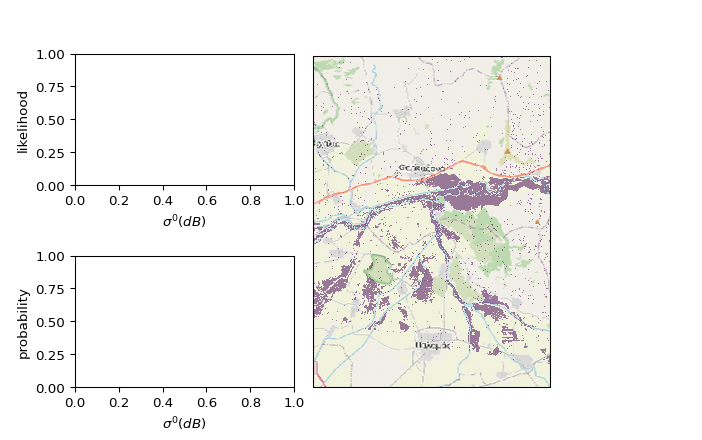

In [7]:
#| label: fig-clas
#| fig-cap: 'Die Ausdehnung der Überschwemmungen in der griechischen Region Thessalien auf der Grundlage von Bayes''schen Wahrscheinlichkeiten wird auf der Karte über einer offenen Straßenkarte angezeigt. Klicken Sie auf ein Pixel, um die Wasser- und Landwahrscheinlichkeiten des Punktes sowie die posterioren Wahrscheinlichkeiten zu generieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.'
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)